In [1]:
import multiprocessing as mp

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [58]:
import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional
import copy
import gc
import multiprocessing as mp

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

In [169]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('ggplot')

In [255]:
def time_indexed_df(df1: pd.core.frame.DataFrame, columname: str) -> pd.core.frame.DataFrame:
    """ 
        Cast into a time-indexed dataframe.
        df1 paramater should have a column containing datetime-like data,
        which contains entries of type pandas._libs.tslibs.timestamps.Timestamp
        or a string containing a compatible datetime (i.e. pd.to_datetime)
    """
    
    _tmp = df1.copy()
    
    pool = mp.Pool()
    _tmp[columname] = pool.map(pd.to_datetime, _tmp[columname])
    pool.close()
    pool.terminate()
    
    _tmp.index = _tmp[columname]
    _tmp.drop(columname, axis=1, inplace=True)
    _tmp = _tmp.sort_index()
    
    return _tmp
##

def dist_plot(series: pd.core.series.Series, dropna: bool = True) -> NoReturn:
    """
    """
    
    if dropna:
        series = series.dropna()
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_box.set(xlabel='')
##


In [442]:
hba1c = lambda x: (x + 105) / 36.5

In [437]:
x = pd.read_csv('data/CareLink-Export-03-ene-2020.csv')
x["DateTime"] =  x["Date"] + " " + x["Time"]
x.drop(["Date", "Time"], axis=1, inplace=True)

/usr/local/anaconda3/envs/diab/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,8,9,10,13,14,16,17,18,34,37,39,41,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [438]:
y = time_indexed_df(x, 'DateTime')
y['hour'] = y.index.hour

In [439]:
# Deltas within minutes
for i in range(1, 11):
    y[f'd{i}'] = y['Sensor Glucose (mg/dL)'].diff(i)

In [440]:
whole = y.copy()

In [443]:
hba1c(whole['Sensor Glucose (mg/dL)'].dropna().mean())

6.816782579594637

In [444]:
y = y.loc['2019-12-25':, :]

In [498]:
hba1c(y['Sensor Glucose (mg/dL)'].dropna().mean())

6.836982797883894

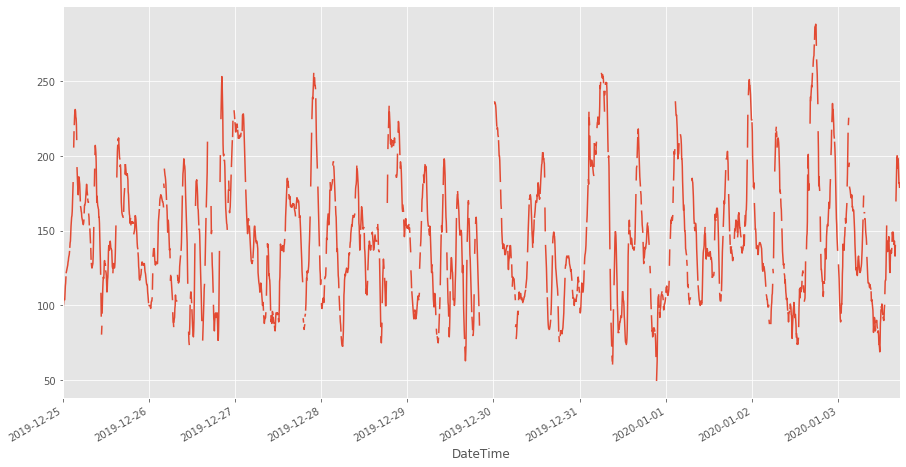

In [445]:
y['Sensor Glucose (mg/dL)'].plot()

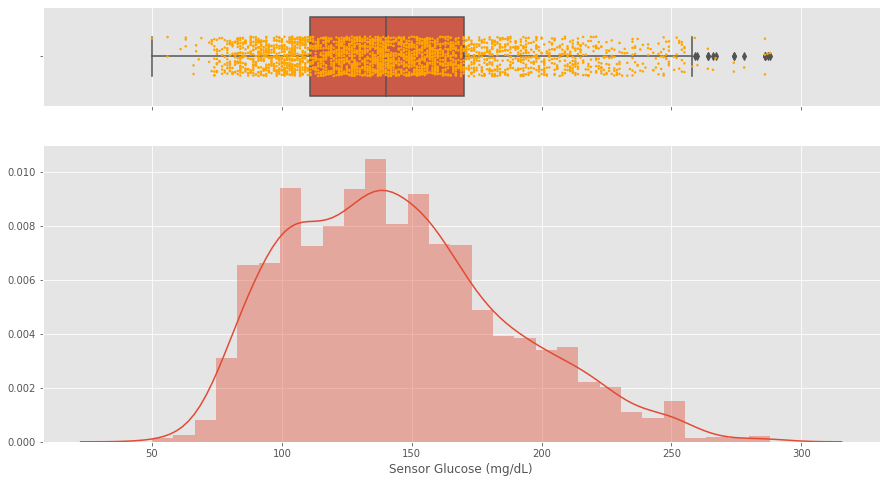

In [446]:
dist_plot(y['Sensor Glucose (mg/dL)'])

In [447]:
y.columns

Index(['Index', 'New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'P

In [448]:
keyword = 'SUSPEND BEFORE LOW'
alarms  = []
for i in y.Alarm.dropna().unique().tolist():
    if keyword in i:
        alarms.append(i)
alarms

['SUSPEND BEFORE LOW ALARM, QUIET',
 'SUSPEND BEFORE LOW ALARM, PATIENT UNRESPONSIVE, MEDICAL DEVICE EMERGENCY']

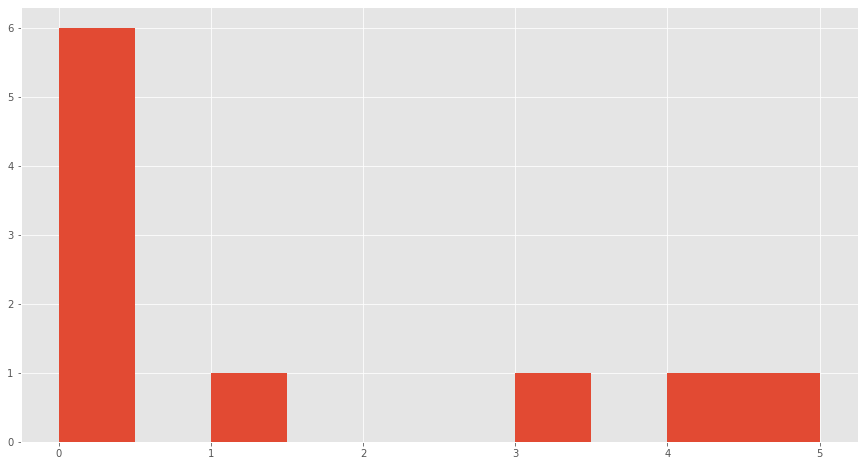

In [449]:
y[ y.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()

In [450]:
#meal_id = y['BWZ Carb Input (grams)'].dropna().index
nonull_meals = y['BWZ Carb Input (grams)'].dropna()
nonull_meals = nonull_meals[ nonull_meals > 0 ]
meal_id = nonull_meals.index
print(len(meal_id))

42


In [451]:
y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna().index ==  meal_id

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [483]:
dt10 = dt.timedelta(minutes=10)
dtpost_low = dt.timedelta(hours=1, minutes=40)
dtpost_high = dt.timedelta(hours=2, minutes=20)

In [484]:
meal_descriptive = pd.core.frame.DataFrame({
    'hour': meal_id.hour, 
    'pre prandial': [ 
        y.loc[ meal - dt10 : meal + dt10,  'Sensor Glucose (mg/dL)' ].dropna().mean()
        for meal in meal_id
    ],
    'post mean': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().mean() 
        for meal in meal_id
    ],
    'post std': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().std() 
        for meal in meal_id
    ], 
    'post min': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().min() 
        for meal in meal_id
    ],
    'post max': [
        y.loc[ meal + dtpost_low : meal + dtpost_high, 'Sensor Glucose (mg/dL)'].dropna().max() 
        for meal in meal_id
    ],
}, index=meal_id)

meal_descriptive['delta'] = meal_descriptive['post mean'] - meal_descriptive['pre prandial'] 
meal_descriptive['ratio'] = y.loc[meal_id, 'BWZ Carb Ratio (g/U)'].dropna()

In [485]:
meal_descriptive.loc[  meal_descriptive.hour < 6, 'meal' ] = 'night'
meal_descriptive.loc[ (meal_descriptive.hour >= 6)  & (meal_descriptive.hour < 9), 'meal'  ] = 'breakfast'
meal_descriptive.loc[ (meal_descriptive.hour >= 9)  & (meal_descriptive.hour < 12), 'meal' ] = 'lunch'
meal_descriptive.loc[ (meal_descriptive.hour >= 12) & (meal_descriptive.hour < 19), 'meal' ] = 'afternoon'
meal_descriptive.loc[ (meal_descriptive.hour >= 19) & (meal_descriptive.hour < 24), 'meal' ] = 'dinner'

In [486]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2019-12-25 08:17:57,8,126.50,146.500,15.380879,121.0,164.0,20.000,10.0,breakfast
2019-12-25 08:42:56,8,159.75,106.625,21.347047,81.0,138.0,-53.125,10.0,breakfast
2019-12-25 14:53:33,14,158.50,163.750,6.181770,159.0,175.0,5.250,12.0,afternoon
2019-12-25 19:44:44,19,152.50,120.500,3.464102,117.0,127.0,-32.000,18.0,dinner
2019-12-26 07:50:08,7,108.25,192.750,3.240370,188.0,198.0,84.500,10.0,breakfast


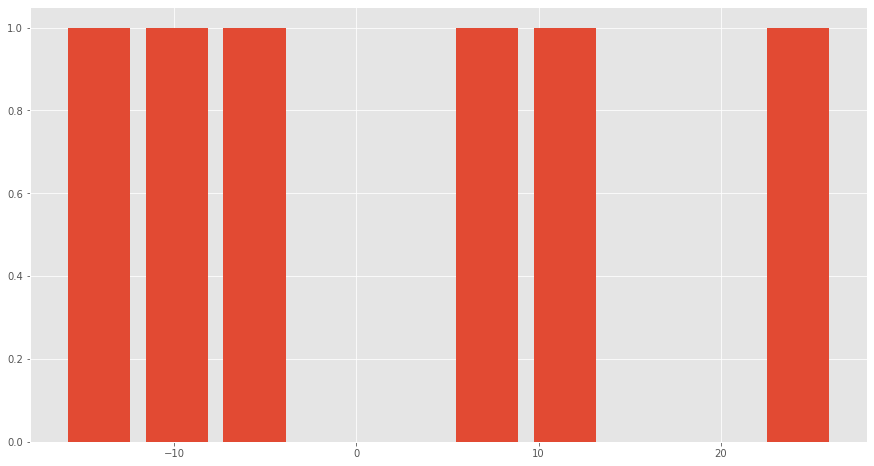

In [494]:
meal_descriptive[ meal_descriptive.meal ==  'lunch' ].delta.hist(rwidth=0.8)

In [495]:
print(meal_descriptive[ meal_descriptive.meal == 'dinner'].describe())

            hour  pre prandial   post mean   post std    post min    post max  \
count  12.000000     12.000000   12.000000  12.000000   12.000000   12.000000   
mean   20.750000    145.333333  146.062500   8.570388  133.833333  158.250000   
std     1.658312     40.171979   28.267769   4.938347   25.957424   31.674839   
min    19.000000     97.000000  109.500000   2.777460  105.000000  113.000000   
25%    19.000000    109.000000  124.000000   4.580627  115.250000  135.000000   
50%    20.500000    148.000000  145.125000   8.230484  125.500000  156.000000   
75%    22.250000    164.062500  156.875000  10.846698  151.000000  168.500000   
max    23.000000    219.250000  217.000000  19.111982  195.000000  235.000000   

           delta  ratio  
count  12.000000   12.0  
mean    0.729167   18.0  
std    44.729898    0.0  
min   -67.375000   18.0  
25%   -30.125000   18.0  
50%     8.875000   18.0  
75%    15.000000   18.0  
max    98.250000   18.0  


In [496]:
meal_descriptive.head()

,hour,pre prandial,post mean,post std,post min,post max,delta,ratio,meal
DateTime,,,,,,,,,
2019-12-25 08:17:57,8,126.50,146.500,15.380879,121.0,164.0,20.000,10.0,breakfast
2019-12-25 08:42:56,8,159.75,106.625,21.347047,81.0,138.0,-53.125,10.0,breakfast
2019-12-25 14:53:33,14,158.50,163.750,6.181770,159.0,175.0,5.250,12.0,afternoon
2019-12-25 19:44:44,19,152.50,120.500,3.464102,117.0,127.0,-32.000,18.0,dinner
2019-12-26 07:50:08,7,108.25,192.750,3.240370,188.0,198.0,84.500,10.0,breakfast


In [497]:
column    = 'delta'

print(column, '\n')
for i in set(meal_descriptive.meal):
    _tmp =  meal_descriptive[ meal_descriptive.meal == i ].describe().T
    print(i, '\n', f"Mean: {int(_tmp['mean'][column])}, Std: {int(_tmp['std'][column])}", '\n\n')

delta 

lunch 
 Mean: 3, Std: 15 


dinner 
 Mean: 0, Std: 44 


afternoon 
 Mean: -2, Std: 62 


night 
 Mean: 17, Std: 129 


breakfast 
 Mean: 4, Std: 52 




In [464]:
postp = [
    y.loc[ 
        meal + dt.timedelta(hours=1, minutes=30) : meal + dt.timedelta(hours=3), 
        ['Sensor Glucose (mg/dL)', 'hour', *[f'd{i}' for i in range(1, 11)]] 
    ].dropna()
    for meal in meal_id
]

postp = pd.concat(postp)
postp.rename({
    'Sensor Glucose (mg/dL)': 'post points', 'b': 'Y'
}, axis='columns', inplace=True)

postp.head()

,post points,hour,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10
DateTime,,,,,,,,,,,,
2019-12-25 09:51:58,166.0,9,-1.0,-4.0,-7.0,-3.0,-15.0,-30.0,-36.0,-39.0,-41.0,-35.0
2019-12-25 09:56:58,165.0,9,-1.0,-2.0,-5.0,-8.0,-4.0,-16.0,-31.0,-37.0,-40.0,-42.0
2019-12-25 16:51:59,159.0,16,-1.0,-1.0,-2.0,-3.0,-6.0,-10.0,-19.0,-32.0,-35.0,-34.0
2019-12-26 10:51:59,115.0,10,-13.0,-27.0,-34.0,-39.0,-46.0,-52.0,-58.0,-66.0,-75.0,-78.0
2019-12-27 13:52:00,144.0,13,3.0,4.0,8.0,8.0,7.0,4.0,5.0,6.0,7.0,6.0


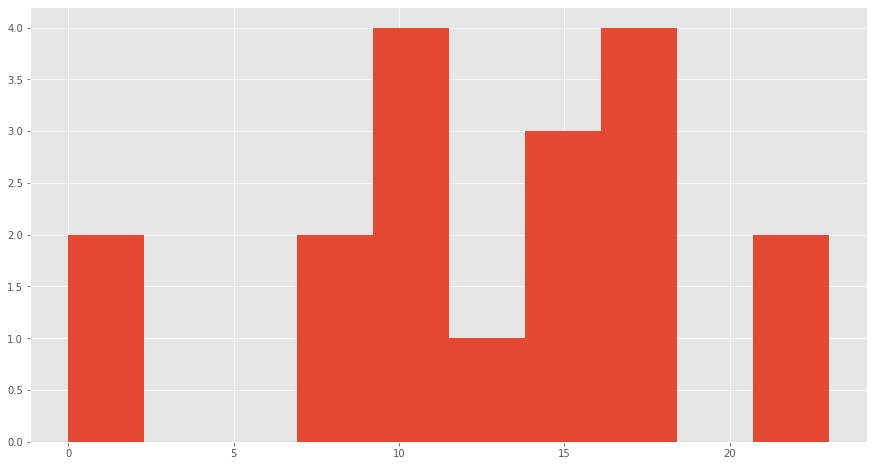

In [465]:
postp.hour.hist()

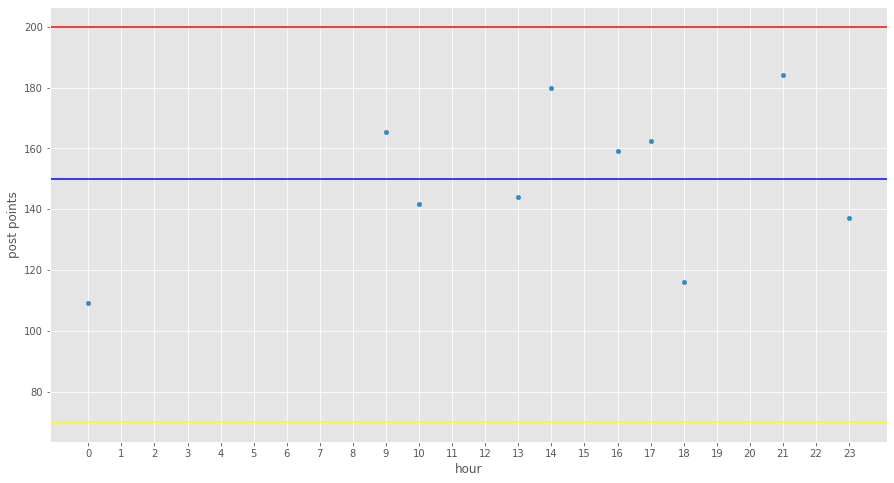

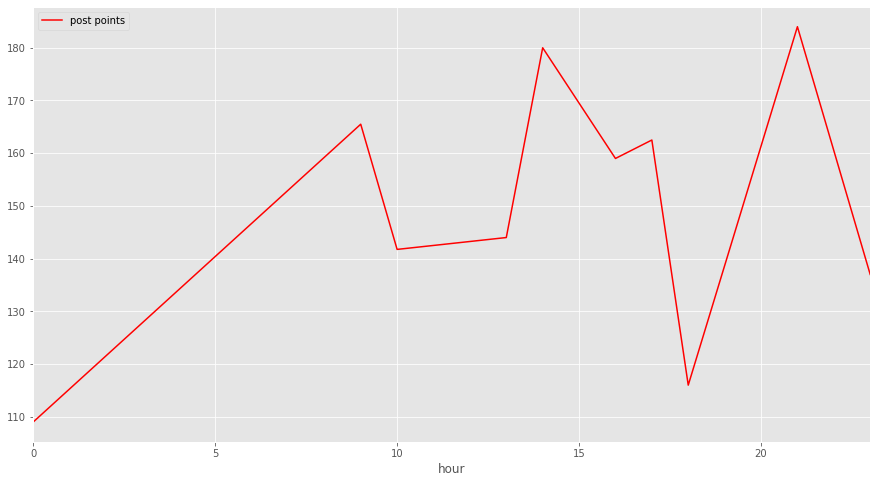

In [466]:
postp.groupby(postp.index.hour).mean().plot(
    x='hour', y='post points', kind='scatter', grid=True, xticks=list(range(24))
)
plt.axhline(150, color='blue')
plt.axhline(200, color='red')
plt.axhline(70, color='yellow')
postp.groupby(postp.index.hour).mean().plot(x='hour', y='post points', color='red')

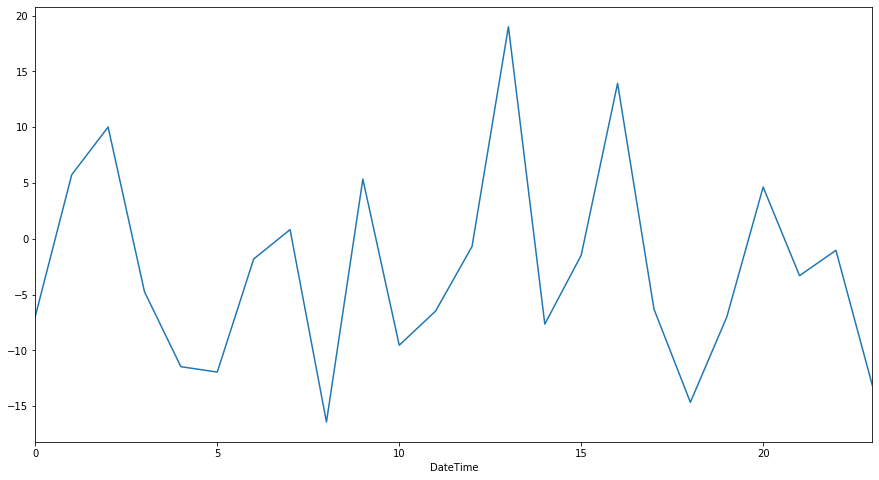

In [107]:
y['Sensor Glucose (mg/dL)'].diff(10).groupby(y.index.hour).mean().plot()

In [190]:
y.groupby('hour')['Sensor Glucose (mg/dL)'].mean()

hour
0     138.897436
1     147.233333
2     164.491667
3     169.858333
4     160.416667
5     143.483333
6     142.008333
7     146.458333
8     124.316667
9     134.258333
10    130.516667
11    112.475000
12    115.575000
13    140.091667
14    142.400000
15    142.016949
16    165.539823
17    164.283019
18    139.800000
19    134.528302
20    145.980769
21    153.375000
22    164.385417
23    156.750000
Name: Sensor Glucose (mg/dL), dtype: float64

In [112]:
hourly_mean = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).mean()
hourly_std  = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std()

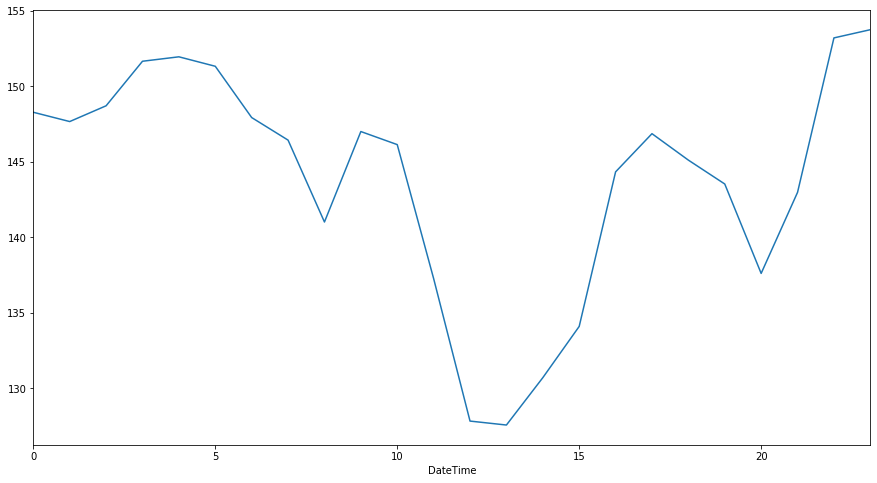

In [28]:
hourly_mean.plot()

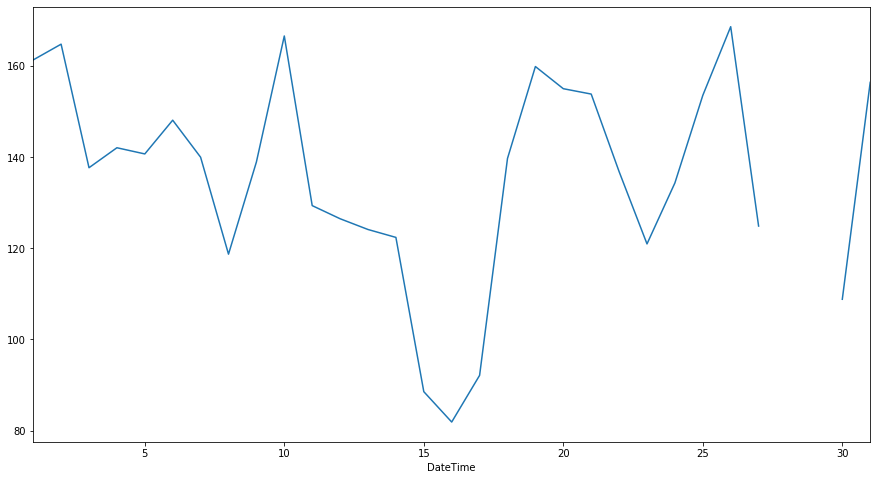

In [13]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).mean().plot()

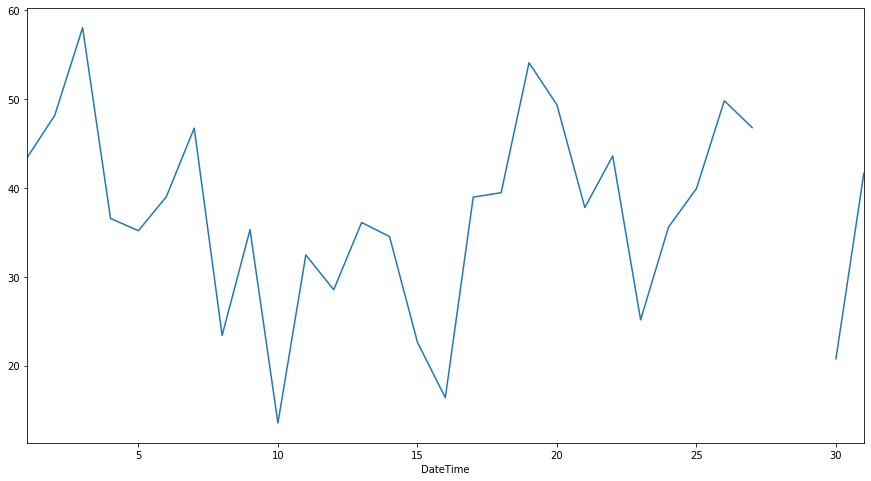

In [14]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.day).std().plot()

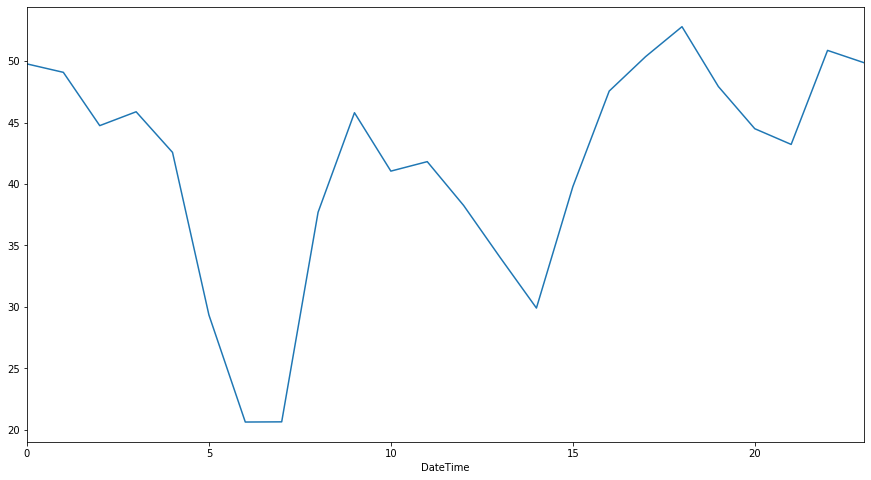

In [15]:
y['Sensor Glucose (mg/dL)'].groupby(y.index.hour).std().plot()

In [16]:
hourly_std.apply(lambda x: x/hourly_std.shape[0])

DateTime
0     2.073550
1     2.044991
2     1.864391
3     1.911366
4     1.773769
5     1.222983
6     0.860092
7     0.860734
8     1.570875
9     1.908137
10    1.710272
11    1.742381
12    1.593854
13    1.418132
14    1.246334
15    1.657384
16    1.981485
17    2.098222
18    2.199657
19    1.996871
20    1.853964
21    1.800740
22    2.119320
23    2.077687
Name: Sensor Glucose (mg/dL), dtype: float64

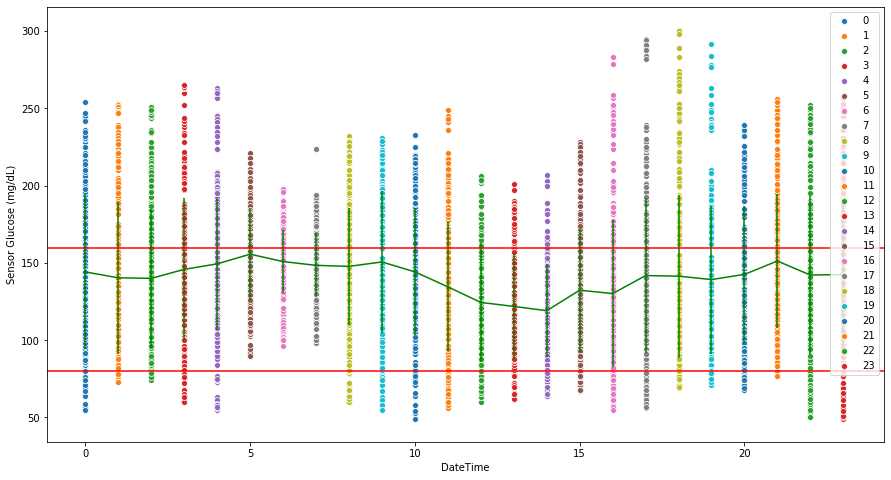

In [17]:
by_hour = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)
for i in by_hour:
    sns.scatterplot(i[1].dropna().index.hour, i[1].dropna(), label=f"{i[0]}")
    
plt.errorbar(
    hourly_mean.index, 
    hourly_mean.to_list(), 
    yerr=hourly_std.apply(lambda x: x).to_list(),
    c='green'
)

plt.axhline(160, c='red')
plt.axhline(80, c='red')

In [18]:
z = y['Sensor Glucose (mg/dL)'].groupby(y.index.hour)

In [19]:
for i in z:
    pass
    #sns.scatterplot(i[1].dropna().index.hour, i[1].dropna())
    #print(i[1].dropna())
    #plt.figure()
    #plt.title(f"Hour {i[0]}")
    #sns.distplot(i[1].dropna())

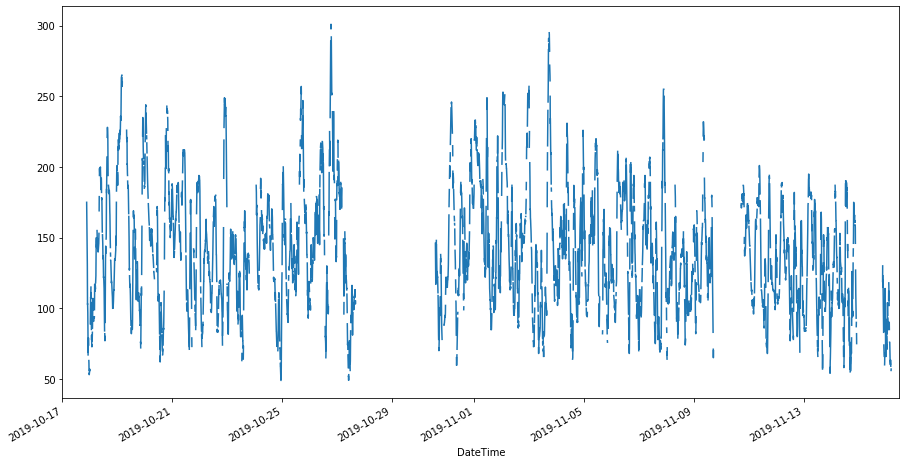

In [20]:
y['Sensor Glucose (mg/dL)'].plot()

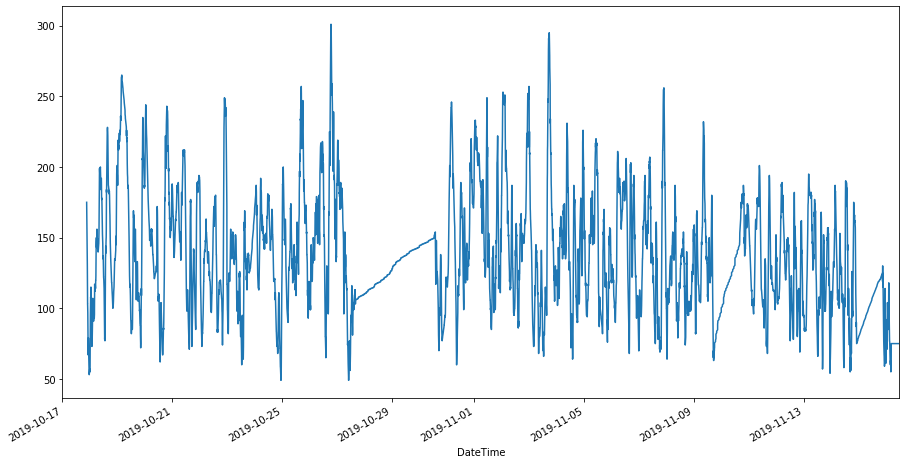

In [21]:
y['Sensor Glucose (mg/dL)'].interpolate().plot()

In [161]:
df = y['Sensor Glucose (mg/dL)']
df[np.bitwise_not(df.index.duplicated())]

DateTime
2019-10-17 00:00:00   NaN
2019-10-17 01:00:00   NaN
2019-10-17 01:11:00   NaN
2019-10-17 01:12:00   NaN
2019-10-17 02:00:00   NaN
                       ..
2019-11-16 10:50:46   NaN
2019-11-16 11:00:00   NaN
2019-11-16 11:09:43   NaN
2019-11-16 11:14:00   NaN
2019-11-16 11:46:13   NaN
Name: Sensor Glucose (mg/dL), Length: 9416, dtype: float64

In [174]:
time_series = y['Sensor Glucose (mg/dL)']
time_series =  time_series[~df.index.duplicated()].interpolate()
print(time_series.dropna().head(), '\n\n', y['Sensor Glucose (mg/dL)'].dropna())
#time_series.plot()
#decomp = seasonal_decompose(time_series)

DateTime
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
2019-10-17 21:35:55    143.0
Name: Sensor Glucose (mg/dL), dtype: float64 

 DateTime
2019-10-17 21:10:55    175.0
2019-10-17 21:15:55    169.0
2019-10-17 21:20:55    164.0
2019-10-17 21:25:55    158.0
2019-10-17 21:30:55    152.0
                       ...  
2019-11-16 04:17:47     55.0
2019-11-16 04:22:47     58.0
2019-11-16 04:27:47     56.0
2019-11-16 04:32:47     57.0
2019-11-16 04:37:47     75.0
Name: Sensor Glucose (mg/dL), Length: 6800, dtype: float64


In [148]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, freq=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages
    
    Parameters
    ----------
    x : array-like
        Time series. If 2d, individual series are in columns.
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If F